In [60]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
from numba import njit

from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.optimize import least_squares

In [16]:
RANDOM_SEED = 10 
rng = np.random.default_rng(RANDOM_SEED)

In [19]:
# Setup. 
n_time_step = 365*3

## Latex macros

$$
\newcommand{\state}{x}
\newcommand{\Time}{t}
\newcommand{\timeIdx}{k}
\newcommand{\indexTime}[2][\timeIdx]{{#2}_{#1}}
\newcommand{\firstTimeIdxState}{0}
\newcommand{\firstTimeIdxObs}{1}
\newcommand{\timeInitState}{\indexTime[\firstTimeIdxState]{\Time}}
\newcommand{\timeInitObs}{\indexTime[\firstTimeIdxObs]{\Time}}
\newcommand{\stateInit}{\state_{\firstTimeIdxState}}
\newcommand{\stateInitObs}{\state_{\firstTimeIdxObs}}
\newcommand{\stateApprox}{\hat{\state}}
\newcommand{\timeEnd}{T}
\newcommand{\Ntime}{K} % Number of time steps 
\newcommand{\lastTimeIdx}{\Ntime} % May or may not be equal to \Ntime depending on whether indexing starts from one or zero, etc. 
\newcommand{\timeStep}{h}
\newcommand{\funcODE}{f}
\newcommand{\forcing}{w}
\newcommand{\stateTime}[1][\timeIdx]{\indexTime[{#1}]{\state}}
\newcommand{\forcingTime}[1][\timeIdx]{\indexTime[{#1}]{\forcing}}
\newcommand{\fwdOne}{g} % One-step forward operator (flow map) 
\newcommand{\dimState}{P}
\newcommand{\stateIdx}{p}
\newcommand{\indexState}[2][\stateIdx]{{#2}^{(#1)}}
\newcommand{\stateV}{\state_{\text{v}}}
\newcommand{\stateR}{\state_{\text{r}}}
\newcommand{\stateS}{\state_{\text{s}}}
\newcommand{\dstateV}{\dot{\state}_{\text{v}}}
\newcommand{\dstateR}{\dot{\state}_{\text{r}}}
\newcommand{\dstateS}{\dot{\state}_{\text{s}}}
\newcommand{\NPP}{\textrm{NPP}}
\newcommand{\GPP}{\textrm{GPP}}
\newcommand{\alphaV}{\alpha_{\text{v}}}
\newcommand{\tauV}{\tau_{\text{v}}}
\newcommand{\tauR}{\tau_{\text{r}}}
\newcommand{\tauS}{\tau_{\text{s}}}
\newcommand{\LUE}{\ell}
\newcommand{\LAR}{r}
\newcommand{\KEXT}{\kappa}
\newcommand{\fracRespiration}{\gamma}
\newcommand{\LAI}{\textrm{LAI}}
$$

# The Very Simple Ecosystem Model (VSEM) 


## State Equations 
$$
\begin{align}
\dstateV(\Time) &= \alphaV \NPP(\stateV(\Time), \forcing(\Time)) - \frac{\stateV(\Time)}{\tauV} \\
\dstateR(\Time) &= (1.0 - \alphaV) \NPP(\stateV(\Time), \forcing(\Time)) - \frac{\stateR(\Time)}{\tauR} \nonumber \\ 
\dstateS(\Time) &= \frac{\stateR(\Time)}{\tauR} + \frac{\stateV(\Time)}{\tauV} - \frac{\stateS(\Time)}{\tauS}
\end{align}
$$

## Model Driver
$$
\begin{align}
\NPP(\stateV, \forcing) &= (1 - \fracRespiration) \GPP(\stateV, \forcing) \\
\GPP(\stateV, \forcing) &= \forcing \cdot \LUE \cdot \left[1 - \exp\left\{-\KEXT \cdot \LAI(\stateV) \right\} \right] \\
\LAI(\stateV) &= \LAR \cdot \stateV.
\end{align} 
$$

In [2]:
# VSEM Defaults 
par_priors = [["KEXT", "Uniform", 2e-01, 1.0],
              ["LAR", "Uniform", 2e-01, 3.0], 
              ["LUE", "Uniform", 5e-04, 4e-03],
              ["GAMMA", "Uniform", 2e-01, 6e-01],
              ["tauV", "Uniform", 5e+02, 3e+03], 
              ["tauS", "Uniform", 4e+03, 5e+04], 
              ["tauR", "Uniform", 5e+02, 3e+03], 
              ["Av", "Uniform", 2e-01, 1.0], 
              ["Cv", "Uniform", 0.0, 4e+2], 
              ["Cs", "Uniform", 0.0, 1e+03], 
              ["Cr", "Uniform", 0.0, 2e+02]]
par_priors = pd.DataFrame(par_priors, columns=["par_name", "dist", "param1", "param2"])
par_priors

,par_name,dist,param1,param2
0,KEXT,Uniform,0.2000,1.000
1,LAR,Uniform,0.2000,3.000
2,LUE,Uniform,0.0005,0.004
3,GAMMA,Uniform,0.2000,0.600
4,tauV,Uniform,500.0000,3000.000
5,tauS,Uniform,4000.0000,50000.000
6,tauR,Uniform,500.0000,3000.000
7,Av,Uniform,0.2000,1.000
8,Cv,Uniform,0.0000,400.000
9,Cs,Uniform,0.0000,1000.000


In [37]:
# Define the default and "true" parameter vectors. 

par_default = rng.uniform(low=par_priors.param1, high=par_priors.param2)
par_true = par_default

In [11]:
# Choose Calibration parameters. 
par_names_cal = ["KEXT", "Cr"]
par_priors["calibrate"] = par_priors.par_name.isin(par_names_cal)
par_cal_idx = np.where(par_priors.calibrate)[0]
par_priors

,par_name,dist,param1,param2,calibrate
0,KEXT,Uniform,0.2000,1.000,True
1,LAR,Uniform,0.2000,3.000,False
2,LUE,Uniform,0.0005,0.004,False
3,GAMMA,Uniform,0.2000,0.600,False
4,tauV,Uniform,500.0000,3000.000,False
5,tauS,Uniform,4000.0000,50000.000,False
6,tauR,Uniform,500.0000,3000.000,False
7,Av,Uniform,0.2000,1.000,False
8,Cv,Uniform,0.0000,400.000,False
9,Cs,Uniform,0.0000,1000.000,False


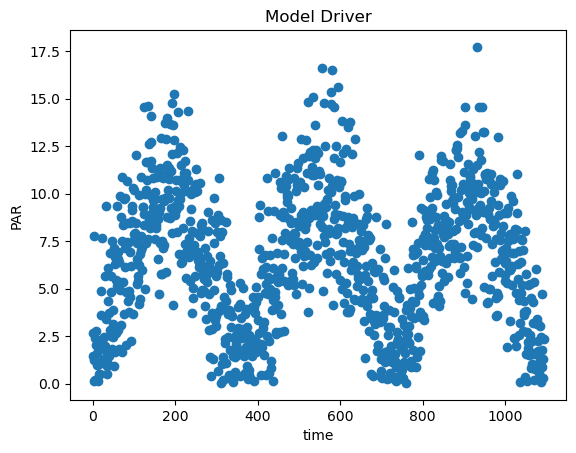

In [68]:
# Note that time t here is in days, so t=1 is 1 day and t=365 is 1 year. 

def get_PAR_driver(n_days):
    time_steps = np.arange(n_days)
    PAR = 10 * np.abs(np.sin(time_steps/365 * np.pi) + 0.25 * rng.normal(size=n_days)) 
    return time_steps, PAR

time_steps, model_driver = get_PAR_driver(n_time_step)
plt.plot(time_steps, model_driver, "o")
plt.xlabel("time")
plt.ylabel("PAR")
plt.title("Model Driver")
plt.show()

In [98]:
# Represent the "right-hand size" (i.e., the time derivatives) of the VSEM model. The forcing data is given at a 
# daily time frequency, so we integrate the model forward in intervals of length 1 (i.e., one day) at a time. 
# An alternative would be an Euler-type scheme that walks the model forward one day at a time (this is how VSEM 
# is implemented in R). 

@njit
def vsem_rhs(t, x, par, w):
    # unpack parameters
    xv, xr, xs = x
    k, lar, lue, gamma, tauv, taus, taur, av, cv, cs, cr = par

    # Compute NPP. 
    npp = (1-gamma) * lue * w * (1 - np.exp(-k * lar * xv)) 
    
    # Compute state derivatives. 
    dxv_dt = av * npp - xv/tauv
    dxr_dt = (1-av) * npp - xr/taur
    dxs_dt = xr/taur + xv/tauv - xs/taus
    
    return [dxv_dt, dxr_dt, dxs_dt]

# The forward model defining the inverse problem. 
def fwd(par):
    par_curr = par_default
    par_curr[par_cal_idx] = par
    init_cond = par_curr[-3:]
    model_out = np.empty(shape=(n_time_step, 3))
    model_out[0,:] = init_cond

    for day in range(1, n_time_step):
        w = model_driver[day]
        model_out_day = solve_ivp(vsem_rhs, y0=init_cond, t_span=(0,1), t_eval=[1], args=(par_curr, w)).y[:,0]
        model_out[day,:] = model_out_day
        init_cond = model_out_day    

    return model_out

In [77]:
par_curr = par_default
model_test = solve_ivp(vsem_rhs, y0=par_curr[-3:], t_span=(0,1), t_eval=[1], args=(par_curr, model_driver[0]))

In [99]:
output = fwd(par_true[par_cal_idx])

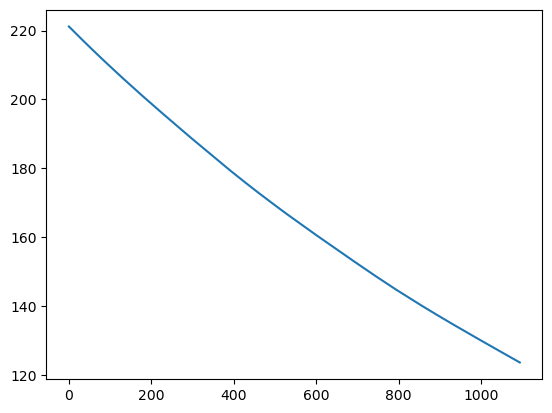

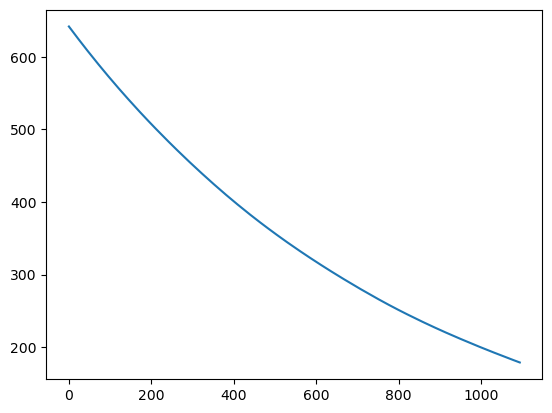

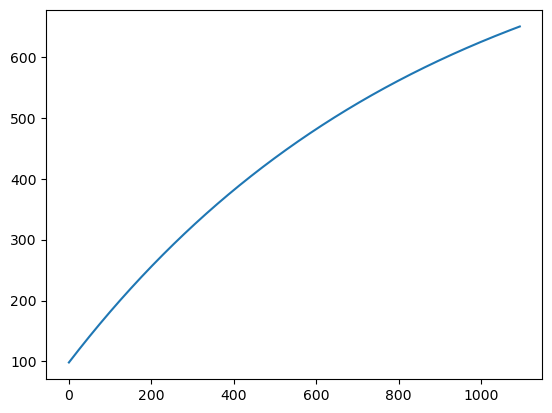

In [104]:
for j in range(output.shape[1]):
    plt.plot(time_steps, output[:,j])
    plt.show()
